In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#import model
from model import Model_10
import matplotlib.pyplot as plt
import dataset
import train


In [2]:
SEED = 1


cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

train_data = dataset.train()
test_data = dataset.test()
if cuda:
    batch_size = 512
    shuffle = True
    num_workers = 4
    pin_memory = True
    train_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,train_data)
    test_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,test_data)
else:
    batch_size =256
    shuffle = True
    num_workers =2
    pin_memory = True
    train_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,train_data)
    test_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,test_data)


CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


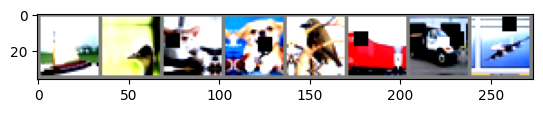

ship  bird  cat   dog  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [4]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_10().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

 80%|████████  | 80/100 [00:26<00:06,  3.05it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 8.11E-04


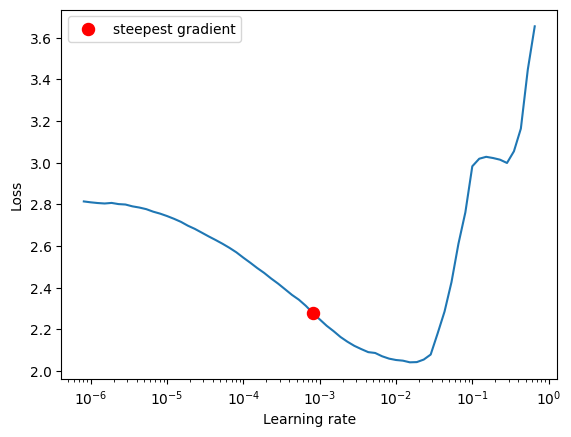

In [7]:
from torch_lr_finder import LRFinder

model = Model_10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
xs, max_lr = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [8]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24
print(max_lr)
scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=10,
        three_phase=False,
        final_div_factor=1,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc, train_losses = train.train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test_acc, test_losses = train.test(model, device, test_loader, criterion)
    print(scheduler.get_last_lr())

0.0008111308307896874
EPOCH: 0


Loss=1.196256399154663 LR=0.00022741520838704733 Batch_id=97 Accuracy=45.22: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s] 



Test set: Average loss: 0.0022, Accuracy: 5975/10000 (59.75%)

[0.00022741520838704733]
EPOCH: 1


Loss=0.8864501118659973 LR=0.00037371733369512587 Batch_id=97 Accuracy=63.50: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]



Test set: Average loss: 0.0018, Accuracy: 6834/10000 (68.34%)

[0.00037371733369512587]
EPOCH: 2


Loss=0.7643245458602905 LR=0.0005200194590032045 Batch_id=97 Accuracy=71.41: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s] 



Test set: Average loss: 0.0015, Accuracy: 7323/10000 (73.23%)

[0.0005200194590032045]
EPOCH: 3


Loss=0.5978291630744934 LR=0.000666321584311283 Batch_id=97 Accuracy=76.26: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s] 



Test set: Average loss: 0.0014, Accuracy: 7497/10000 (74.97%)

[0.000666321584311283]
EPOCH: 4


Loss=0.5885419845581055 LR=0.0008107387697006914 Batch_id=97 Accuracy=78.49: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.0013, Accuracy: 7630/10000 (76.30%)

[0.0008107387697006914]
EPOCH: 5


Loss=0.5232073664665222 LR=0.0007723167829790746 Batch_id=97 Accuracy=80.11: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s] 



Test set: Average loss: 0.0011, Accuracy: 8164/10000 (81.64%)

[0.0007723167829790746]
EPOCH: 6


Loss=0.5840523838996887 LR=0.0007338947962574578 Batch_id=97 Accuracy=81.87: 100%|██████████| 98/98 [00:54<00:00,  1.80it/s] 



Test set: Average loss: 0.0012, Accuracy: 7976/10000 (79.76%)

[0.0007338947962574578]
EPOCH: 7


Loss=0.4443051815032959 LR=0.0006954728095358411 Batch_id=97 Accuracy=82.88: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s] 



Test set: Average loss: 0.0011, Accuracy: 8094/10000 (80.94%)

[0.0006954728095358411]
EPOCH: 8


Loss=0.39241114258766174 LR=0.0006570508228142243 Batch_id=97 Accuracy=84.22: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]



Test set: Average loss: 0.0014, Accuracy: 7740/10000 (77.40%)

[0.0006570508228142243]
EPOCH: 9


Loss=0.4521212875843048 LR=0.0006186288360926074 Batch_id=97 Accuracy=84.77: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s] 



Test set: Average loss: 0.0012, Accuracy: 7846/10000 (78.46%)

[0.0006186288360926074]
EPOCH: 10


Loss=0.4385589361190796 LR=0.0005802068493709907 Batch_id=97 Accuracy=85.59: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s] 



Test set: Average loss: 0.0014, Accuracy: 7490/10000 (74.90%)

[0.0005802068493709907]
EPOCH: 11


Loss=0.3883635997772217 LR=0.0005417848626493739 Batch_id=97 Accuracy=86.14: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s] 



Test set: Average loss: 0.0009, Accuracy: 8493/10000 (84.93%)

[0.0005417848626493739]
EPOCH: 12


Loss=0.3921147882938385 LR=0.0005033628759277572 Batch_id=97 Accuracy=86.88: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s] 



Test set: Average loss: 0.0011, Accuracy: 8073/10000 (80.73%)

[0.0005033628759277572]
EPOCH: 13


Loss=0.3586088716983795 LR=0.0004649408892061404 Batch_id=97 Accuracy=87.46: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]  



Test set: Average loss: 0.0009, Accuracy: 8391/10000 (83.91%)

[0.0004649408892061404]
EPOCH: 14


Loss=0.377193808555603 LR=0.00042651890248452366 Batch_id=97 Accuracy=88.00: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]  



Test set: Average loss: 0.0010, Accuracy: 8302/10000 (83.02%)

[0.00042651890248452366]
EPOCH: 15


Loss=0.30696648359298706 LR=0.0003880969157629069 Batch_id=97 Accuracy=88.40: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s] 



Test set: Average loss: 0.0009, Accuracy: 8444/10000 (84.44%)

[0.0003880969157629069]
EPOCH: 16


Loss=0.244267538189888 LR=0.0003496749290412901 Batch_id=97 Accuracy=89.13: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]   



Test set: Average loss: 0.0008, Accuracy: 8534/10000 (85.34%)

[0.0003496749290412901]
EPOCH: 17


Loss=0.3197719156742096 LR=0.0003112529423196733 Batch_id=97 Accuracy=90.08: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]  



Test set: Average loss: 0.0009, Accuracy: 8462/10000 (84.62%)

[0.0003112529423196733]
EPOCH: 18


Loss=0.2918021082878113 LR=0.0002728309555980566 Batch_id=97 Accuracy=90.72: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]  



Test set: Average loss: 0.0009, Accuracy: 8541/10000 (85.41%)

[0.0002728309555980566]
EPOCH: 19


Loss=0.26198631525039673 LR=0.00023440896887643977 Batch_id=97 Accuracy=91.30: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.0009, Accuracy: 8568/10000 (85.68%)

[0.00023440896887643977]
EPOCH: 20


Loss=0.2901454269886017 LR=0.00019598698215482306 Batch_id=97 Accuracy=92.20: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s] 



Test set: Average loss: 0.0007, Accuracy: 8781/10000 (87.81%)

[0.00019598698215482306]
EPOCH: 21


Loss=0.20298798382282257 LR=0.00015756499543320625 Batch_id=97 Accuracy=93.00: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]



Test set: Average loss: 0.0006, Accuracy: 9021/10000 (90.21%)

[0.00015756499543320625]
EPOCH: 22


Loss=0.22137980163097382 LR=0.00011914300871158944 Batch_id=97 Accuracy=94.01: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]



Test set: Average loss: 0.0006, Accuracy: 9051/10000 (90.51%)

[0.00011914300871158944]
EPOCH: 23


Loss=0.14951401948928833 LR=8.072102198997274e-05 Batch_id=97 Accuracy=95.04: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s] 



Test set: Average loss: 0.0005, Accuracy: 9129/10000 (91.29%)

[8.072102198997274e-05]


In [ ]:
train.plot_loss_accuracy(train_losses,train_acc,test_losses,test_acc)